# Bioactivity models training without Qptuna

Many technical problems with Qptuna due to current updates and no clear connection with Reinvent

Note: I will use count Morgan fingerprints instead of the bits (to be able to perform polynomial regression, and also because it seems that models trained on count fingerprints features are more performant).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from data_preprocessing import MorganECFPBits, MorganECFPCounts
from splitter import Splitter

In [3]:
from pickle import dump, load

In [2]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

## Logistic regression

#### JAK2

Jak2 is a kinase. We have 667 measurements (pIC50) for potential active molecules for jak2. Experts labelled them s.t. if pIC50 > 8, label = 1 (active) otherwise label = 0 (inactive). We compute Morgan fingerprint counts as molecular features instead of bits because it was shown that hashing of Morgan fingerprints descriptors (i.e. generating the bits) for QSAR modeling has a negative effect on predictive performance, with no significant improvement in computational efficiency. 

We use the open-source Python framework RDKit to compute the Morgan fingerprints. The Morgan algorithm initially assigns an integer identifier to each non-hydrogen atom, then iteratively, by extending the connectivity of each atom to its neighbouring atoms, updates the numerical identifiers based on these neighbouring atoms. 

There are mainly two parameters to be set for the generation of the Morgan fingerprint: 
(1) the bit size (or hash size) i.e. the length of the bit string for the molecular features to be contained in
(2) the radius i.e. the number of neighbours × bond lengths away to take into account when calculating the identifiers of the atoms. 

One problem with hashed (binary) fingerprints is fingerprint collisions. A fingerprint collision occurs when a feature falls into a bin (a column) of another feature resulting in more than one molecular substructure being compressed into a single, now hashed, feature. 

It is also possible to use an unhashed version of the fingerprint, which means that the compression of the bit string is bypassed and hence encode explicitly defined patterns: the fingerprint counts.

Example of a fingerprint bit collision from Riniker et al. (2013):
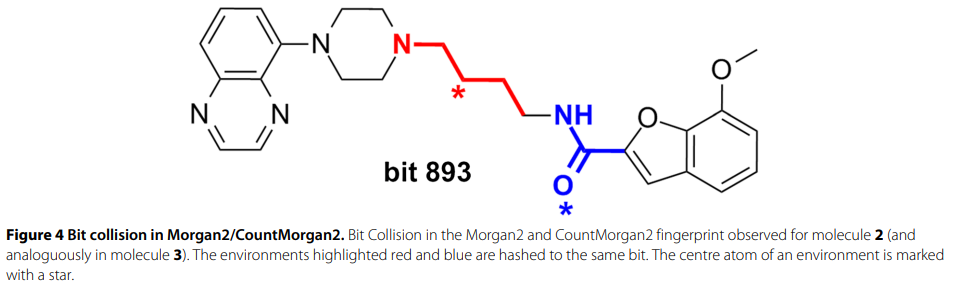

Results from Kensert et al. (2018) showed that unhashed fingerprints (i.e. the counts) yield significantly better accuracy than hashed fingerprints (p≤0.05), with no pronounced deterioration in modeling time and memory usage, and easier interpretation. 

We split the data into train (70%) and test (30%) sets using a stratified split. We fit a 

- [X] logistic regression classifier
- [X] random forest classifier

on the train set using a 3-fold cross-validation. We apply a grid search to find the hyperparameters (regularizer C high and low limits, solver) that maximize our objective (maximum balanced accuracy on validation folds). Grid search is a "greedy" type fastest-ascent algorithm that proceeds heuristically. A starting solution for the hyperparameters is chosen at random.



In [5]:
#load data

jak2 = pd.read_csv("data/jak2/all.csv", sep = ",")

In [6]:
jak2.head()

,smiles,value,label
0,NC(=O)c1cn(nc1Nc2ccnc(F)c2)C3(CC#N)CCN(Cc4cccn...,6.84,0
1,CN(C1CCC(CC#N)(CC1)n2cc(C(=O)N)c(Nc3ccnc(F)c3)...,6.98,0
2,NC(=O)c1cn(nc1Nc2ccc(F)cc2)C3(CC#N)CCN(CC3)C(=...,7.48,0
3,NC(=O)c1cn(nc1Nc2ccnc(F)c2)C3(CC#N)CCN(CC3)C(=...,8.05,1
4,NC(=O)c1cn(nc1Nc2ccnc(F)c2)C3(CC#N)CCC(CC3)NCc...,8.70,1


In [7]:
jak2.rename(columns = {"label": "activity"}, inplace = True)

In [8]:
#compute ECFP6 counts

ecfp_calculator = MorganECFPCounts(jak2)
jak2_ecfp_counts = ecfp_calculator.compute_ecfp_counts(path_name = "data/jak2/all_")

In [9]:
#split data

list_col = [f"bit{i}" for i in range(jak2_ecfp_counts.iloc[:,3:].shape[1])]
act_col = ["activity"]

jak2_splitter = Splitter(jak2_ecfp_counts, list_col, act_col)
jak2_train, jak2_test = jak2_splitter.split_data(split_strategy = "stratified")

jak2_train.to_csv("data/jak2/ECFP_counts_train.csv")
jak2_test.to_csv("data/jak2/ECFP_counts_test.csv")

In [10]:
X_train = jak2_train.iloc[:,2:].values
y_train = jak2_train.activity.values

In [11]:
X_test = jak2_test.iloc[:,2:].values
y_test = jak2_test.activity.values

In [12]:
#do the grid search

# Grid Search is a "greedy" type fastest-ascent algorithm that proceeds heuristically. 
# A starting solution is chosen at random.

grid = {
    "C": np.linspace(0.001, 1000, num = 10),
    "solver": ["newton-cg", "lbfgs", "sag", "saga"]
}

logreg = LogisticRegression(max_iter = 10000)
logreg_cv = GridSearchCV(
    logreg, 
    grid, 
    cv = 5, 
    scoring = "roc_auc",
    return_train_score = True,
    error_score= "raise",
    verbose = 2,
    n_jobs = -1
)

logreg_cv.fit(X_train, y_train)

print("Best parameters :", logreg_cv.best_params_)
print("Best metrics :", logreg_cv.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.1min finished
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters : {'C': 111.11200000000001, 'solver': 'saga'}
Best metrics : 0.818438370604623


In [13]:
# save best model
jak2_bioactivity_estimator = logreg_cv.best_estimator_
dump(jak2_bioactivity_estimator, open("bioactivity_models/jak2/jak2_logreg_ecfpcounts_best.pkl", "wb"))

# Load
jak2_bioactivity_estimator = load(open("bioactivity_models/jak2/jak2_logreg_ecfpcounts_best.pkl", "rb"))

In [14]:
jak2_test = pd.read_csv("data/jak2/ECFP_counts_test.csv", sep = ",", index_col=0)

X_test = jak2_test.iloc[:,2:].values
y_test = jak2_test.activity.values

In [15]:
confusion_matrix(y_test, jak2_bioactivity_estimator.predict(X_test))

array([[138,  14],
       [ 30,  19]])

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02):
    #When PCA dimensionality reduction is applied beforehand
    
    #setup color map
    colors = ("red", "green", "lightgreen", "cyan", "gray")
    markers = ('s', 'x', 'o', '^', 'v')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #plot the decision surface
    X1_min, X1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    X2_min, X2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(X1_min, X1_max, resolution), np.arange(X2_min, X2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha = 0.5, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1], alpha=0.8, color=cmap(idx), marker=markers[idx], label=cl)

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='black', alpha=1.0, linewidth=1, marker='+', s=55, label='test set')

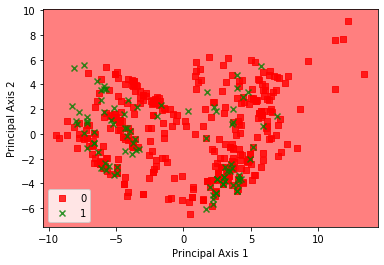

In [17]:
pca = PCA(n_components = 2)
logreg_2PC = LogisticRegression(max_iter = 10000, C = 111.11200000000001, solver = "saga")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

logreg_2PC.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier = logreg_2PC)

plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend(loc = "lower left")
plt.show()

Training a logistic regression after a PCA dimensionality reduction of ECFP counts is not good. There is loss of information about data variability as PC1 and PC2 only explain 44% of the variability in the data.

In [18]:
vsum = sum(pca.explained_variance_ratio_)
print('Total Explained Variance {:.2%}'.format(vsum))

Total Explained Variance 45.67%


In [19]:
confusion_matrix(y_train, logreg_2PC.predict(X_train_pca))

array([[375,   0],
       [ 91,   0]])

Training on all ECFP count features results in a better classification.

In [20]:
confusion_matrix(y_train, jak2_bioactivity_estimator.predict(X_train))

array([[366,   9],
       [ 13,  78]])

In [21]:
# retrain on both train and test

jak2_all_ecfp_counts = pd.read_csv("data/jak2/all_ECFP_counts.csv", index_col = 0)
X = jak2_all_ecfp_counts.iloc[:, 1:].values
y = jak2_all_ecfp_counts.activity.values

merged_jak2_bioactivity_estimator = LogisticRegression(C = 111.11200000000001, max_iter = 10000, solver = "saga")

merged_jak2_bioactivity_estimator.fit(X, y)

LogisticRegression(C=111.11200000000001, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)

In [22]:
dump(merged_jak2_bioactivity_estimator, open("bioactivity_models/jak2/MERGED_jak2_logreg_ecfpcounts_best.pkl", "wb"))

#### DRD2

In [23]:
#load data

drd2 = pd.read_csv("data/drd2/all.csv", sep = ",")

In [24]:
drd2.head()

,smiles,label
0,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](NC(=O)N3CCNC3=...,0
1,[Na+].CN(CS(=O)(=O)[O-])C1=C(C)N(C)N(C1=O)c2cc...,0
2,C(\C=C\c1ccccc1)N2CCN(CC2)C(c3ccccc3)c4ccccc4,1
3,CC(CCc1ccc(O)cc1)NCCc2ccc(O)c(O)c2,0
4,CN1CCC[C@@H]1CCO[C@](C)(c2ccccc2)c3ccc(Cl)cc3,1


In [25]:
drd2.rename(columns = {"label": "activity"}, inplace = True)

In [26]:
#compute ECFP counts

ecfp_calculator = MorganECFPCounts(drd2)
drd2_ecfp_counts = ecfp_calculator.compute_ecfp_counts(path_name = "data/drd2/all_")

In [27]:
#split data

list_col = [f"bit{i}" for i in range(drd2_ecfp_counts.iloc[:,2:].shape[1])]
act_col = ["activity"]

drd2_splitter = Splitter(drd2_ecfp_counts, list_col, act_col)
drd2_train, drd2_test = drd2_splitter.split_data(split_strategy = "stratified")

drd2_train.to_csv("data/drd2/ECFP_counts_train.csv")
drd2_test.to_csv("data/drd2/ECFP_counts_test.csv")

In [28]:
X_train = drd2_train.iloc[:,2:].values
y_train = drd2_train.activity.values

In [29]:
#do the grid search

grid = {
    "C": np.linspace(0.001, 1000, num = 10),
    "solver": ["newton-cg", "lbfgs", "sag", "saga"]
}

logreg = LogisticRegression(max_iter = 10000)
logreg_cv = GridSearchCV(
    logreg, 
    grid, 
    cv = 3, 
    scoring = "roc_auc",
    return_train_score = True,
    error_score= "raise",
    verbose = 2,
    n_jobs = -1
)

logreg_cv.fit(X_train, y_train)

print("Best parameters :", logreg_cv.best_params_)
print("Best metrics :", logreg_cv.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.9min finished
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters : {'C': 111.11200000000001, 'solver': 'lbfgs'}
Best metrics : 0.8902330267355736


In [30]:
# save best model
drd2_bioactivity_estimator = logreg_cv.best_estimator_

dump(drd2_bioactivity_estimator, open("bioactivity_models/drd2/drd2_logreg_ecfpcounts_best.pkl", "wb"))

drd2_bioactivity_estimator = load(open("bioactivity_models/drd2/drd2_logreg_ecfpcounts_best.pkl", "rb"))

In [46]:
# retrain on both train and test

drd2_all_ecfp_counts = pd.read_csv("data/drd2/all_ECFP_counts.csv", index_col = 0)
X = drd2_all_ecfp_counts.iloc[:, 1:].values
y = drd2_all_ecfp_counts.activity.values

merged_drd2_bioactivity_estimator = LogisticRegression(C = 111.11200000000001, max_iter = 10000, solver = "lbfgs")

merged_drd2_bioactivity_estimator.fit(X, y)

LogisticRegression(C=111.11200000000001, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [47]:
dump(merged_drd2_bioactivity_estimator, open("bioactivity_models/drd2/MERGED_drd2_logreg_ecfpcounts_best.pkl", "wb"))

#### EGFR

In [6]:
#load data
egfr = pd.read_csv("data/egfr/all.csv", sep = ",")

In [7]:
egfr.head()

,smiles,label
0,CC(C)NCC(O)c1ccccc1Cl,0
1,CO[C@]1(NC(=O)CSCC#N)[C@H]2SCC(=C(N2C1=O)C(=O)...,0
2,CCN1C[C@]2(COC)[C@H](O)C[C@@H](OC)[C@@]34[C@@H...,0
3,[Cl-].COc1cc2CC[N+](C)(C)[C@@H]3Cc4ccc(O)c(Oc5...,0
4,CNCCc1ccccn1,0


In [8]:
egfr.rename(columns = {"label": "activity"}, inplace = True)

In [9]:
#compute ECFP counts

ecfp_calculator = MorganECFPCounts(egfr)
egfr_ecfp_counts = ecfp_calculator.compute_ecfp_counts(path_name = "data/egfr/all_")

In [10]:
#split data

list_col = [f"bit{i}" for i in range(egfr_ecfp_counts.iloc[:,2:].shape[1])]
act_col = ["activity"]

egfr_splitter = Splitter(egfr_ecfp_counts, list_col, act_col)
egfr_train, egfr_test = egfr_splitter.split_data(split_strategy = "stratified")

egfr_train.to_csv("data/egfr/ECFP_counts_train.csv")
egfr_test.to_csv("data/egfr/ECFP_counts_test.csv")

In [11]:
X_train = egfr_train.iloc[:,2:].values
y_train = egfr_train.activity.values

In [12]:
#do the grid search

grid = {
    "C": np.linspace(0.001, 1000, num = 10),
    "solver": ["newton-cg", "lbfgs", "sag", "saga"]
}

logreg = LogisticRegression(max_iter = 10000)
logreg_cv = GridSearchCV(
    logreg, 
    grid, 
    cv = 3, 
    scoring = "roc_auc",
    return_train_score = True,
    error_score= "raise",
    verbose = 2,
    n_jobs = -1
)

logreg_cv.fit(X_train, y_train)

print("Best parameters :", logreg_cv.best_params_)
print("Best metrics :", logreg_cv.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.4min finished
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters : {'C': 888.889, 'solver': 'newton-cg'}
Best metrics : 0.8522272995460513


In [13]:
# save best model
egfr_bioactivity_estimator = logreg_cv.best_estimator_

dump(egfr_bioactivity_estimator, open("bioactivity_models/egfr/egfr_logreg_ecfpcounts_best.pkl", "wb"))
# Somewhere else
egfr_bioactivity_estimator = load(open("bioactivity_models/egfr/egfr_logreg_ecfpcounts_best.pkl", "rb"))

In [44]:
# retrain on both train and test

egfr_all_ecfp_counts = pd.read_csv("data/egfr/all_ECFP_counts.csv", index_col = 0)
X = egfr_all_ecfp_counts.iloc[:, 1:].values
y = egfr_all_ecfp_counts.activity.values

merged_egfr_bioactivity_estimator = LogisticRegression(C = 888.889, max_iter = 10000, solver = "newton-cg")

merged_egfr_bioactivity_estimator.fit(X, y)

LogisticRegression(C=888.889, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
dump(merged_egfr_bioactivity_estimator, open("bioactivity_models/egfr/MERGED_egfr_logreg_ecfpcounts_best.pkl", "wb"))

## Polynomial logistic regression

Does it make sense to calculate polynomial features when FP bits are binary ?

Maybe could be useful with 2D RDKit descriptors (or ECFP counts), but not with binary ECFPs.

Also requires more work on Reinvent to enable computing polynomial features for all new generated molecules.

#### JAK2

In [1]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

In [2]:
jak2_train = pd.read_csv("data/jak2/ECFP_counts_train.csv")
jak2_test = pd.read_csv("data/jak2/ECFP_counts_test.csv")

In [3]:
X_train = jak2_train.iloc[:,2:].values
y_train = jak2_train.activity.values

In [4]:
X_test = jak2_test.iloc[:,2:].values
y_test = jak2_test.activity.values

In [5]:
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
logreg = LogisticRegression(max_iter = 10000)

logreg.fit(poly_X_train, y_train)

In [14]:
ypred = logreg.predict(poly_X_test)

print(confusion_matrix(y_test, ypred))

[[162   0]
 [  0  39]]


## Random forest classifier

#### JAK2

In [16]:
jak2_train = pd.read_csv("data/jak2/ECFP_counts_train.csv")
jak2_test = pd.read_csv("data/jak2/ECFP_counts_test.csv")

X_train = jak2_train.iloc[:,3:].values
y_train = jak2_train.activity.values

In [17]:
X_train.shape

(466, 2048)

In [18]:
#do the grid search

grid = {
    'n_estimators': [200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8, 10],
    'criterion' :['gini', 'entropy']
}

rf_clf = RandomForestClassifier()
rf_clf_cv = GridSearchCV(
    rf_clf, 
    grid, 
    cv = 5, 
    scoring = "roc_auc",
    return_train_score = True,
    error_score= "raise",
    verbose = 2,
    n_jobs = -1
)

rf_clf_cv.fit(X_train, y_train)

print("Best parameters :", rf_clf_cv.best_params_)
print("Best metrics :", rf_clf_cv.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.3min finished
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters : {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Best metrics : 0.8491159049268379


In [19]:
# save best model
jak2_bioactivity_estimator = rf_clf_cv.best_estimator_

dump(jak2_bioactivity_estimator, open("bioactivity_models/jak2/jak2_rf_ecfpcounts_best.pkl", "wb"))
# Somewhere else
jak2_bioactivity_estimator = load(open("bioactivity_models/jak2/jak2_rf_ecfpcounts_best.pkl", "rb"))

In [20]:
rf_clf_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
# retrain on both train and test

jak2_all_ecfp_counts = pd.read_csv("data/jak2/all_ECFP_counts.csv", index_col = 0)

if jak2_all_ecfp_counts.iloc[:, 1:].shape[1] == 2048:
    X = jak2_all_ecfp_counts.iloc[:, 1:].values
    y = jak2_all_ecfp_counts.activity.values

    merged_jak2_bioactivity_estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

    merged_jak2_bioactivity_estimator.fit(X, y)
    
else:
    print("Shape is not good")

In [42]:
merged_jak2_bioactivity_estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
dump(merged_jak2_bioactivity_estimator, open("bioactivity_models/jak2/MERGED_jak2_rf_ecfpcounts_best.pkl", "wb"))

#### DRD2

In [2]:
import pandas as pd

drd2_train = pd.read_csv("data/drd2/ECFP_counts_train.csv")
drd2_test = pd.read_csv("data/drd2/ECFP_counts_test.csv")

X_train = drd2_train.iloc[:,3:].values
X_test = drd2_test.iloc[:,3:].values
print(X_train.shape)
y_train = drd2_train.activity.values
print(X_test.shape)

(589, 2048)
(253, 2048)


In [109]:
drd2_train = pd.read_csv("data/drd2/ECFP_counts_train_oracle.csv", index_col=0)
drd2_test = pd.read_csv("data/drd2/ECFP_counts_test_oracle.csv", index_col=0)

In [112]:
list_col = [f"bit{i}" for i in range(drd2_data.iloc[:,1:].shape[1])]
act_col = ["oracle"]

#drd2_splitter = Splitter(drd2_data, feat_col=list_col, tar_col=act_col)
#drd2_train, drd2_test = drd2_splitter.split_data(frac=0.1, split_strategy="stratified")

X_train = drd2_train.iloc[:,1:-1].values
X_test = drd2_test.iloc[:,1:-1].values

y_train = drd2_train.oracle.values
y_test = drd2_test.oracle.values

print(X_train.shape)
print(X_test.shape)

#X = drd2_data.iloc[:,1:].values
#y = drd2_data.activity.values

(757, 2048)
(85, 2048)


In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score

def evaluate(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"AUC : {auc}\n")
    print(f"Recall : {recall}\n")
    print(f"Precision : {precision}\n")
    print(f"F1-score : {f1}\n")

rf_drd2 = RandomForestClassifier(n_estimators = 300, class_weight={0: 1, 1: 2}, oob_score=True)
rf_drd2.fit(X_train, y_train)

y_pred = rf_drd2.predict(X_test)

evaluate(y_test, y_pred)

AUC : 0.8333333333333333

Recall : 0.6666666666666666

Precision : 1.0

F1-score : 0.8



In [121]:
train = pd.read_csv("/home/klgx638/Projects/reinvent-hitl-calibration/data/drd2/ECFP_counts_train_oracle.csv", sep = ",")
train.iloc[:,2:-1]

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2038,bit2039,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047
0,1,1,1,1,12,0,1,0,4,0,...,0,0,1,0,0,0,0,0,0,0
1,52,11,11,2,0,0,0,0,0,0,...,0,0,11,2,0,0,0,0,0,0
2,2,0,1,1,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,41,0,11,5,0,0,0,0,0,0,...,0,0,1,5,0,1,0,0,0,0
4,5,0,4,0,12,1,2,0,2,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,12,1,4,0,6,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
753,7,1,1,0,6,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
754,1,0,0,0,3,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
755,5,1,3,0,15,0,1,0,3,0,...,0,1,0,0,0,0,0,0,0,0


In [66]:
rf_drd2.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [114]:
import os
import pickle

output_dir = "/home/klgx638/Projects/reinvent-hitl-overfitting/models/drd2"
modelfile = "drd2_qsar_initial.pkl"

filename = os.path.join(output_dir, modelfile)
pickle.dump(rf_drd2, open(filename, "wb"))

In [72]:
predicted_prob = rf_drd2.predict_proba(X_test)
rev = np.sort(predicted_prob, axis=1)[:, ::-1]
values = rev[:, 0] - rev[:, 1]
selection = np.argsort(values)[:num_evaluations]
print(selection)

[61 23 27 47 33 66 71 77 38 43 48 80 17  6 55  9 44  4 52 49 79 45 25  8
 39 14 83 15 67 36]


In [77]:
from sklearn.utils import check_random_state

n = 30
random_state = check_random_state(0)
selection = np.random.choice(X_test.shape[0], n, replace=False)

In [78]:
selection

array([77, 68, 82, 30, 80, 26, 66,  6, 70, 55, 64, 62, 71, 41, 52, 20, 23,
        9, 75, 51, 53, 65, 83, 74, 45, 67, 36, 48, 78, 69])

In [4]:
#do the grid search

grid = {
    'n_estimators': [200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8, 10],
    'criterion' :['gini', 'entropy']
}

rf_clf = RandomForestClassifier()
rf_clf_cv = GridSearchCV(
    rf_clf, 
    grid, 
    cv = 5, 
    scoring = "roc_auc",
    return_train_score = True,
    error_score= "raise",
    verbose = 2,
    n_jobs = -1
)

rf_clf_cv.fit(X_train, y_train)

print("Best parameters :", rf_clf_cv.best_params_)
print("Best metrics :", rf_clf_cv.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.6min finished
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters : {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 500}
Best metrics : 0.9201114625956138


In [26]:
# save best model
drd2_bioactivity_estimator = rf_clf_cv.best_estimator_

dump(drd2_bioactivity_estimator, open("bioactivity_models/drd2/drd2_rf_ecfpcounts_best.pkl", "wb"))
# Somewhere else
drd2_bioactivity_estimator = load(open("bioactivity_models/drd2/drd2_rf_ecfpcounts_best.pkl", "rb"))

In [27]:
rf_clf_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
# retrain on both train and test

drd2_all_ecfp_counts = pd.read_csv("data/drd2/all_ECFP_counts.csv", index_col = 0)

if drd2_all_ecfp_counts.iloc[:, 1:].shape[1] == 2048:
    X = drd2_all_ecfp_counts.iloc[:, 1:].values
    y = drd2_all_ecfp_counts.activity.values

    merged_drd2_bioactivity_estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

    merged_drd2_bioactivity_estimator.fit(X, y)
    
else:
    print("Shape is not good")

In [38]:
merged_drd2_bioactivity_estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
dump(merged_drd2_bioactivity_estimator, open("bioactivity_models/drd2/MERGED_drd2_rf_ecfpcounts_best.pkl", "wb"))

#### EGFR

In [31]:
egfr_train = pd.read_csv("data/egfr/ECFP_counts_train.csv")
egfr_test = pd.read_csv("data/egfr/ECFP_counts_test.csv")

X_train = egfr_train.iloc[:,3:].values
print(X_train.shape)
y_train = egfr_train.activity.values

(589, 2048)


In [32]:
#do the grid search

grid = {
    'n_estimators': [200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8, 10],
    'criterion' :['gini', 'entropy']
}

rf_clf = RandomForestClassifier()
rf_clf_cv = GridSearchCV(
    rf_clf, 
    grid, 
    cv = 5, 
    scoring = "roc_auc",
    return_train_score = True,
    error_score= "raise",
    verbose = 2,
    n_jobs = -1
)

rf_clf_cv.fit(X_train, y_train)

print("Best parameters :", rf_clf_cv.best_params_)
print("Best metrics :", rf_clf_cv.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.6min finished


Best parameters : {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 300}
Best metrics : 0.8890096619653616


In [33]:
# save best model
egfr_bioactivity_estimator = rf_clf_cv.best_estimator_

dump(egfr_bioactivity_estimator, open("bioactivity_models/egfr/egfr_rf_ecfpcounts_best.pkl", "wb"))
# Somewhere else
egfr_bioactivity_estimator = load(open("bioactivity_models/egfr/egfr_rf_ecfpcounts_best.pkl", "rb"))

In [34]:
rf_clf_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
# retrain on both train and test

egfr_all_ecfp_counts = pd.read_csv("data/egfr/all_ECFP_counts.csv", index_col = 0)

if egfr_all_ecfp_counts.iloc[:, 1:].shape[1] == 2048:
    X = egfr_all_ecfp_counts.iloc[:, 1:].values
    y = egfr_all_ecfp_counts.activity.values

    merged_egfr_bioactivity_estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

    merged_egfr_bioactivity_estimator.fit(X, y)
    
else:
    print("Shape is not good")

In [36]:
dump(merged_egfr_bioactivity_estimator, open("bioactivity_models/egfr/MERGED_egfr_rf_ecfpcounts_best.pkl", "wb"))